In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

0.8.1


In [2]:
config = ConfigPaths('config_sample.cfg')
original_model_name = 'phi_model5'
plot_maker = PlotMaker()
printer = PrintHelper()
print config.models_file_name
print config.dataset_path
print config.dataset_folder_name
print config.output_batches_path

Q:\\topic_modeling\\csi_science_collections.git\experiments\ndw_model5\np_19_12\models.txt
Q:\\topic_modeling\\csi_science_collections.git\..\data\postnauka\UCI_collections\ndw_model5
ndw_model5
Q:\\topic_modeling\\csi_science_collections.git\..\data\postnauka\bigARTM_files\ndw_model5


In [6]:
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        print '[{}] column num {} of {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def get_optimization_result_one_matrix(dist_fn, jac_dist_fn, phi, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)
        column = phi[col_name]
        # delete col from phi
        phi_cut = phi.drop(col_name, axis=1)
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_cut, distances)
    return opt_results
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)        
        column = phi[col_name]
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi, distances, verbose=False):
    max_iter = 50
    phi_columns = phi.columns
    # cut distances by phi columns 
    cut_distances = distances[phi_columns]
    # get n closest topics
    closest_column_names = cut_distances.loc[column_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_column_names]
    
    # opt solver
    n_columns = phi_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(column, phi_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(column, phi_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    if not is_optimized:
        print 'Not optimized' 
    res['column_names'] = phi_closest.columns
    res['optimized_column'] = column_name
    res['projection'] = phi_closest.dot(res.x)
    res['column'] = column
    return res

In [15]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model5', 'distances_hellinger_model5', config.output_batches_path)
# phi_original.columns = [u'o_' + col for col in phi_original.columns] 
phi_20_20, theta_20_20, saved_top_tokens_20_20, _ = load_model_pickle('model20')
phi_20_21, theta_20_21, saved_top_tokens_20_21, _ = load_model_pickle('model21')
phi_20_22, theta_20_22, saved_top_tokens_20_22, _ = load_model_pickle('model22')
phi_20_30, theta_20_30, saved_top_tokens_20_30, _ = load_model_pickle('model30')
phi_20_31, theta_20_31, saved_top_tokens_20_31, _ = load_model_pickle('model31')
phi_20_32, theta_20_32, saved_top_tokens_20_32, _ = load_model_pickle('model32')
phi_20_42, theta_20_42, saved_top_tokens_20_42, _ = load_model_pickle('model42')
phi_20_43, theta_20_43, saved_top_tokens_20_43, _ = load_model_pickle('model43')

In [11]:
N_CLOSEST_TOPICS = 50
NUM_INDICES = 10

In [12]:
# # distances between current topics
distances_hellinger_model_20_20_inter = calculate_distances(dh.hellinger_dist, phi_20_20, phi_20_20)
distances_hellinger_model_20_20_original = calculate_distances(dh.hellinger_dist, phi_20_20, phi_original)
save_pickle_file(distances_hellinger_model_20_20_inter, 'distances_hellinger_model_20_20_inter.p')
save_pickle_file(distances_hellinger_model_20_20_original, 'distances_hellinger_model_20_20_original.p')

distances_hellinger_model_20_21_inter = calculate_distances(dh.hellinger_dist, phi_20_21, phi_20_21)
distances_hellinger_model_20_21_original = calculate_distances(dh.hellinger_dist, phi_20_21, phi_original)
save_pickle_file(distances_hellinger_model_20_21_inter, 'distances_hellinger_model_20_21_inter.p')
save_pickle_file(distances_hellinger_model_20_21_original, 'distances_hellinger_model_20_21_original.p')

distances_hellinger_model_20_22_inter = calculate_distances(dh.hellinger_dist, phi_20_22, phi_20_22)
distances_hellinger_model_20_22_original = calculate_distances(dh.hellinger_dist, phi_20_22, phi_original)
save_pickle_file(distances_hellinger_model_20_22_inter, 'distances_hellinger_model_20_22_inter.p')
save_pickle_file(distances_hellinger_model_20_22_original, 'distances_hellinger_model_20_22_original.p')

distances_hellinger_model_20_30_inter = calculate_distances(dh.hellinger_dist, phi_20_30, phi_20_30)
distances_hellinger_model_20_30_original = calculate_distances(dh.hellinger_dist, phi_20_22, phi_original)
save_pickle_file(distances_hellinger_model_20_30_inter, 'distances_hellinger_model_20_30_inter.p')
save_pickle_file(distances_hellinger_model_20_30_original, 'distances_hellinger_model_20_30_original.p')

distances_hellinger_model_20_31_inter = calculate_distances(dh.hellinger_dist, phi_20_31, phi_20_31)
distances_hellinger_model_20_31_original = calculate_distances(dh.hellinger_dist, phi_20_22, phi_original)
save_pickle_file(distances_hellinger_model_20_31_inter, 'distances_hellinger_model_20_31_inter.p')
save_pickle_file(distances_hellinger_model_20_31_original, 'distances_hellinger_model_20_31_original.p')

distances_hellinger_model_20_32_inter = calculate_distances(dh.hellinger_dist, phi_20_32, phi_20_32)
distances_hellinger_model_20_32_original = calculate_distances(dh.hellinger_dist, phi_20_22, phi_original)
save_pickle_file(distances_hellinger_model_20_32_inter, 'distances_hellinger_model_20_32_inter.p')
save_pickle_file(distances_hellinger_model_20_32_original, 'distances_hellinger_model_20_32_original.p')

[2016-12-20 22:27:57.156000] take_distances between 20 columns and 20 columns
[2016-12-20 22:27:57.157000] column num 0 of 20
[2016-12-20 22:27:57.233000] column num 1 of 20
[2016-12-20 22:27:57.258000] column num 2 of 20
[2016-12-20 22:27:57.305000] column num 3 of 20
[2016-12-20 22:27:57.337000] column num 4 of 20
[2016-12-20 22:27:57.385000] column num 5 of 20
[2016-12-20 22:27:57.424000] column num 6 of 20
[2016-12-20 22:27:57.456000] column num 7 of 20
[2016-12-20 22:27:57.503000] column num 8 of 20
[2016-12-20 22:27:57.537000] column num 9 of 20
[2016-12-20 22:27:57.568000] column num 10 of 20
[2016-12-20 22:27:57.643000] column num 11 of 20
[2016-12-20 22:27:57.685000] column num 12 of 20
[2016-12-20 22:27:57.721000] column num 13 of 20
[2016-12-20 22:27:57.752000] column num 14 of 20
[2016-12-20 22:27:57.784000] column num 15 of 20
[2016-12-20 22:27:57.821000] column num 16 of 20
[2016-12-20 22:27:57.873000] column num 17 of 20
[2016-12-20 22:27:57.919000] column num 18 of 20
[

In [ ]:
distances_hellinger_model_20_32_inter = calculate_distances(dh.hellinger_dist, phi_20_43, phi_0_32)
distances_hellinger_model_20_32_original = calculate_distances(dh.hellinger_dist, phi_20_22, phi_original)
save_pickle_file(distances_hellinger_model_20_32_inter, 'distances_hellinger_model_20_32_inter.p')
save_pickle_file(distances_hellinger_model_20_32_original, 'distances_hellinger_model_20_32_original.p')

In [14]:
# opt_res_hellinger_model_20_20_original = get_optimization_result(dh.hellinger_dist, None, phi_20_20, phi_original, distances_hellinger_model_20_20_original)
# save_pickle_file(opt_res_hellinger_model_20_20_original, 'opt_res_hellinger_model_20_20_original.p')
# opt_res_hellinger_model_20_20_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_20, distances_hellinger_model_20_20_inter)
# save_pickle_file(opt_res_hellinger_model_20_20_inter, 'opt_res_hellinger_model_20_20_inter.p')

# opt_res_hellinger_model_20_21_original = get_optimization_result(dh.hellinger_dist, None, phi_20_21, phi_original, distances_hellinger_model_20_21_original)
# save_pickle_file(opt_res_hellinger_model_20_21_original, 'opt_res_hellinger_model_20_21_original.p')
# opt_res_hellinger_model_20_21_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_21, distances_hellinger_model_20_21_inter)
# save_pickle_file(opt_res_hellinger_model_20_21_inter, 'opt_res_hellinger_model_20_21_inter.p')

# opt_res_hellinger_model_20_22_original = get_optimization_result(dh.hellinger_dist, None, phi_20_22, phi_original, distances_hellinger_model_20_22_original)
# save_pickle_file(opt_res_hellinger_model_20_22_original, 'opt_res_hellinger_model_20_22_original.p')
# opt_res_hellinger_model_20_22_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_22, distances_hellinger_model_20_22_inter)
# save_pickle_file(opt_res_hellinger_model_20_22_inter, 'opt_res_hellinger_model_20_22_inter.p')
################# 
opt_res_hellinger_model_20_30_original = get_optimization_result(dh.hellinger_dist, None, phi_20_30, phi_original, distances_hellinger_model_20_30_original)
save_pickle_file(opt_res_hellinger_model_20_30_original, 'opt_res_hellinger_model_20_30_original.p')
opt_res_hellinger_model_20_30_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_30, distances_hellinger_model_20_30_inter)
save_pickle_file(opt_res_hellinger_model_20_30_inter, 'opt_res_hellinger_model_20_30_inter.p')

opt_res_hellinger_model_20_31_original = get_optimization_result(dh.hellinger_dist, None, phi_20_31, phi_original, distances_hellinger_model_20_31_original)
save_pickle_file(opt_res_hellinger_model_20_31_original, 'opt_res_hellinger_model_20_31_original.p')
opt_res_hellinger_model_20_31_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_31, distances_hellinger_model_20_31_inter)
save_pickle_file(opt_res_hellinger_model_20_31_inter, 'opt_res_hellinger_model_20_31_inter.p')

opt_res_hellinger_model_20_32_original = get_optimization_result(dh.hellinger_dist, None, phi_20_32, phi_original, distances_hellinger_model_20_32_original)
save_pickle_file(opt_res_hellinger_model_20_32_original, 'opt_res_hellinger_model_20_32_original.p')
opt_res_hellinger_model_20_32_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi_20_32, distances_hellinger_model_20_32_inter)
save_pickle_file(opt_res_hellinger_model_20_32_inter, 'opt_res_hellinger_model_20_32_inter.p')

[2016-12-20 23:12:49.270000] get_optimization_result for column 0
[2016-12-20 23:13:37.574000] get_optimization_result for column 1
[2016-12-20 23:15:56.847000] get_optimization_result for column 2
[2016-12-20 23:19:51.629000] get_optimization_result for column 3
[2016-12-20 23:22:03.013000] get_optimization_result for column 4
[2016-12-20 23:26:27.417000] get_optimization_result for column 5
[2016-12-20 23:27:24.916000] get_optimization_result for column 6
[2016-12-20 23:28:15.869000] get_optimization_result for column 7
[2016-12-20 23:29:48.003000] get_optimization_result for column 8
[2016-12-20 23:33:03] get_optimization_result for column 9
[2016-12-20 23:34:23.059000] get_optimization_result for column 10
[2016-12-20 23:36:16.522000] get_optimization_result for column 11
[2016-12-20 23:37:33.373000] get_optimization_result for column 12
[2016-12-20 23:38:08.345000] get_optimization_result for column 13
[2016-12-20 23:39:59.832000] get_optimization_result for column 14
[2016-12-20 

In [ ]:
distances_hellinger_model_20_20_inter = load_pickle_file('distances_hellinger_model_20_20_inter.p')
distances_hellinger_model_20_20_original = load_pickle_file('distances_hellinger_model_20_20_original.p')

distances_hellinger_model_20_21_inter = load_pickle_file('distances_hellinger_model_20_21_inter.p')
distances_hellinger_model_20_21_original = load_pickle_file('distances_hellinger_model_20_21_original.p')

distances_hellinger_model_20_22_inter = load_pickle_file('distances_hellinger_model_20_22_inter.p')
distances_hellinger_model_20_22_original = load_pickle_file('distances_hellinger_model_20_22_original.p')

distances_hellinger_model_20_30_inter = load_pickle_file('distances_hellinger_model_20_30_inter.p')
distances_hellinger_model_20_30_original = load_pickle_file('distances_hellinger_model_20_30_original.p')

distances_hellinger_model_20_31_inter = load_pickle_file('distances_hellinger_model_20_31_inter.p')
distances_hellinger_model_20_31_original = load_pickle_file('distances_hellinger_model_20_31_original.p')

distances_hellinger_model_20_32_inter = load_pickle_file('distances_hellinger_model_20_32_inter.p')
distances_hellinger_model_20_32_original = load_pickle_file('distances_hellinger_model_20_32_original.p')

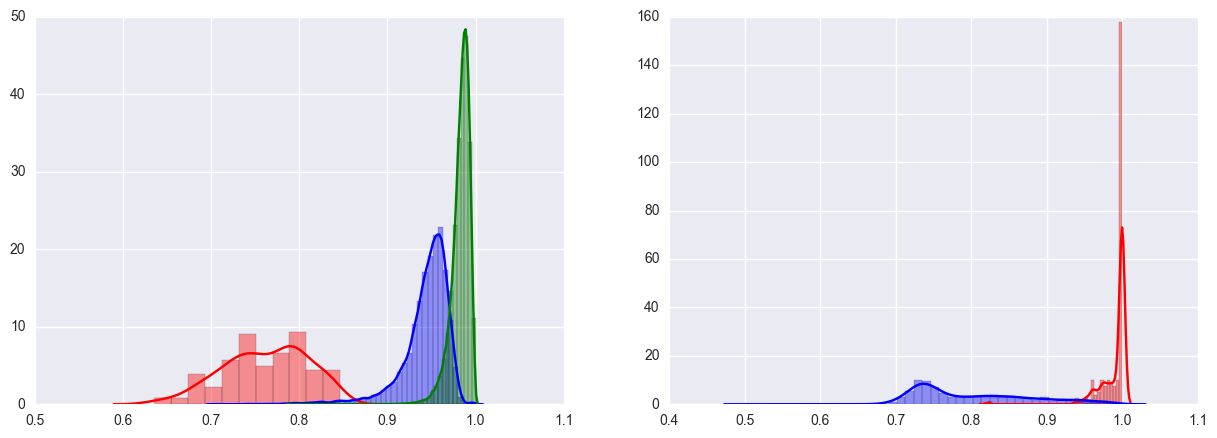

In [61]:
# графики расстояния
# построим распределение полученных distances
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
vals = distances_hellinger_model_20_inter.values.flatten()
sns.distplot(vals[vals != 0], color='r', ax = ax1)
vals = distances_hellinger_model_20_original.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax1)
vals = distances_hellinger_model_original.values.flatten()
sns.distplot(vals[vals != 0],  color='g', ax = ax1)

vals = distances_hellinger_model_20_18_inter.values.flatten()
sns.distplot(vals[vals != 0],  color='r', ax = ax2)
vals = distances_hellinger_model_20_18_original.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax2)

In [ ]:
# 20: друг на друга похожи, но от original в целом по расстоянию далеко
# 20 18: друг на друга не очень похожи, от original в целом далеко

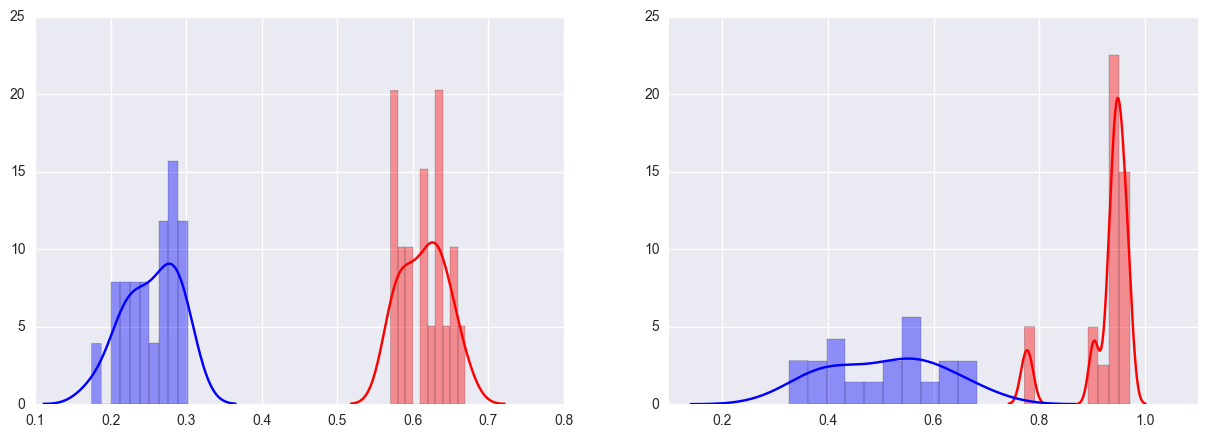

In [28]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.fun for val in opt_res_hellinger_model_20_inter.itervalues()], color='r', bins=10, ax=ax1)
sns.distplot([val.fun for val in opt_res_hellinger_model_20_original.itervalues()], color='b', bins=10, ax=ax1)
sns.distplot([val.fun for val in opt_res_hellinger_model_20_18_inter.itervalues()], color='r', bins=10, ax=ax2)
sns.distplot([val.fun for val in opt_res_hellinger_model_20_18_original.itervalues()], color='b', bins=10, ax=ax2)

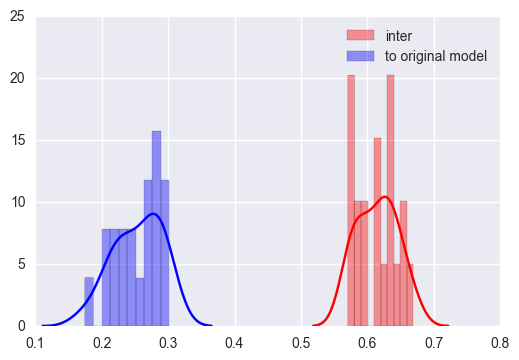

In [90]:
%matplotlib inline
sns.distplot([val.fun for val in opt_res_hellinger_model_20_inter.itervalues()], color='r', bins=10, label='inter')
sns.distplot([val.fun for val in opt_res_hellinger_model_20_original.itervalues()], color='b', bins=10, label='to original model')
plt.legend()

In [85]:
theta_original.shape

(500, 3446)

20: по значениям оптимизируемого функционала также видно, что друг на друга столбцы достаточно похожи, и к original очень близко
20 18: друг на друга столбцы не оч похожи, к original близко, но не сильно

In [32]:
topic_name = u'topic_0'
printer.print_optimal_solution(opt_res_hellinger_model_20_original[topic_name], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)

fun = 0.243694662562, optimized = True
topic_0 | topic_163 : 0.07 [0.80], topic_255 : 0.06 [0.84], topic_351 : 0.06 [0.80], topic_321 : 0.06 [0.81], topic_201 : 0.05 [0.83], topic_332 : 0.05 [0.82], topic_200 : 0.04 [0.81], topic_406 : 0.04 [0.85], topic_155 : 0.04 [0.84], topic_460 : 0.03 [0.85]
closest by distance to topic_0 | topic_7 : [0.87], topic_11 : [0.92], topic_6 : [0.92], topic_18 : [0.92], topic_5 : [0.93], topic_13 : [0.93], topic_16 : [0.94], topic_0 : [0.94], topic_4 : [0.94], topic_15 : [0.94]

topic_0: ребёнок имя семья остров растение предок тысяча вид группа исследование жизнь родитель лицо африка насекомое
topic_163: тысяча неандерталец предок происхождение генетик изменчивость миллион австралопитек сапиенс примат появление древние кроманьонец зуб человечество
topic_255: ребёнок родитель рождение взрослый возраст девочка мама месяц особенность навык сверстник счастие матерь поддержка психолог
topic_351: насекомое растение муравей яд муравьев пчела пестицид коэволюци

In [33]:
topic_name = u'topic_1'
printer.print_optimal_solution(opt_res_hellinger_model_20_original[topic_name], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)

fun = 0.267055236958, optimized = True
topic_1 | topic_38 : 0.09 [0.76], topic_472 : 0.07 [0.82], topic_373 : 0.07 [0.80], topic_190 : 0.07 [0.81], topic_284 : 0.06 [0.81], topic_379 : 0.06 [0.82], topic_305 : 0.06 [0.84], topic_107 : 0.05 [0.85], topic_245 : 0.04 [0.86], topic_467 : 0.04 [0.87]
closest by distance to topic_1 | topic_14 : [0.78], topic_12 : [0.92], topic_8 : [0.92], topic_4 : [0.93], topic_15 : [0.93], topic_11 : [0.93], topic_19 : [0.93], topic_1 : [0.93], topic_3 : [0.93], topic_16 : [0.93]

topic_1: теория вселенная математика движение функция пространство физика физик точка эйнштейн гипотеза результат математик утверждение уравнение
topic_38: реликтовый_излучение флуктуация космология масштаб большой_взрыв параметр излучение распределение момент инфляция теория_инфляция амплитуда стержень наблюдение скопление_галактика
topic_472: математика математик точка геометрия плоскость описание топология теорема простой трёхмерный_пространство размерность количество пуанкара

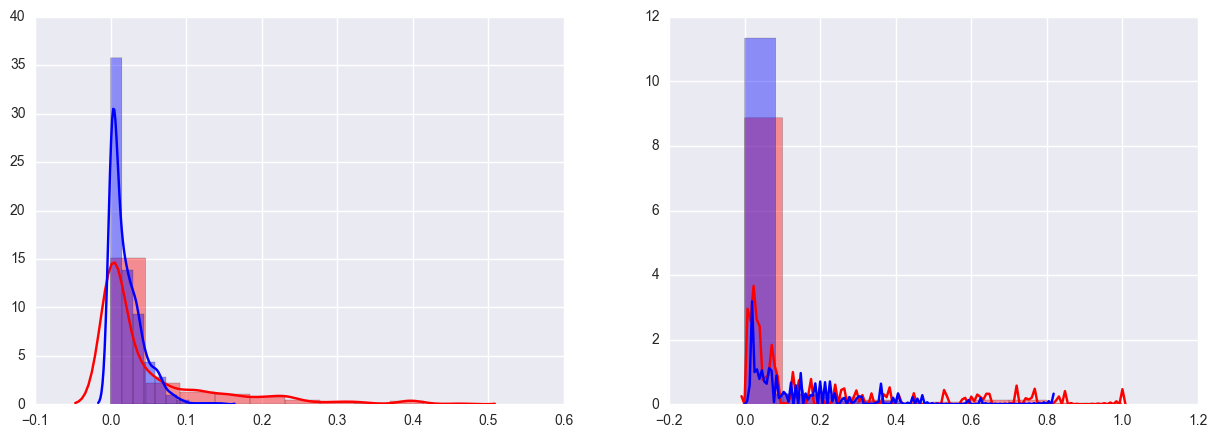

In [29]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([elem for val in opt_res_hellinger_model_20_inter.itervalues() for elem in val.x], color='r', bins=10, ax=ax1)
sns.distplot([elem for val in opt_res_hellinger_model_20_original.itervalues() for elem in val.x], color='b', bins=10, ax=ax1)
sns.distplot([elem for val in opt_res_hellinger_model_20_18_inter.itervalues() for elem in val.x], color='r', bins=10, ax=ax2)
sns.distplot([elem for val in opt_res_hellinger_model_20_18_original.itervalues() for elem in val.x], color='b', bins=10, ax=ax2)

In [ ]:
# по значениям х похоже, что новые темы - сборная солянка старых, всего понемногу
# найдём темы, которые имеют сильный коэффициент х

In [9]:
opt_20_original_string_x0 = [val for val in opt_res_hellinger_model_20_original.itervalues() if val.x[0] > 0.1]
print len(opt_20_original_string_x0)

4


In [14]:
printer.print_optimal_solution(opt_20_original_string_x0[0], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)
printer.print_optimal_solution(opt_20_original_string_x0[1], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)
printer.print_optimal_solution(opt_20_original_string_x0[2], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)
printer.print_optimal_solution(opt_20_original_string_x0[3], _distances=distances_hellinger_model_20_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_1, _other_saved_top_tokens=saved_top_tokens_original)

fun = 0.205133396429, optimized = True
topic_14 | topic_124 : 0.15 [0.74], topic_118 : 0.10 [0.78], topic_1 : 0.07 [0.78], topic_116 : 0.06 [0.80], topic_74 : 0.05 [0.82], topic_384 : 0.04 [0.86], topic_75 : 0.04 [0.83], topic_333 : 0.03 [0.86], topic_459 : 0.03 [0.87], topic_168 : 0.03 [0.86]
closest by distance to topic_14 | topic_13 : [0.90], topic_7 : [0.93], topic_15 : [0.93], topic_6 : [0.94], topic_16 : [0.94], topic_8 : [0.94], topic_14 : [0.94], topic_11 : [0.94], topic_18 : [0.95], topic_12 : [0.95]

topic_14: язык слово русский_язык словарь текст предложение буква речь лингвист значение ошибка конструкция глагол форма часть
topic_124: язык лингвист разный_язык название лингвистика лексика народ английский_язык факт простой различие частность тип изучение_язык термин
topic_118: слово значение название пример русский_язык значение_слово первое предмет выражение фраза определение простой тысяча английский_язык частотность
topic_1: глагол грамматика существительное русский_язык 

In [ ]:
# темы действительно немного похожи
# проверим, что fun - это расстояние между (оптимальный х умноженный на фи, рассматриваемый вектор)

In [23]:
def get_projection(opt_res_one_column, phi, other_phi):
    x = opt_res_one_column.x
    optimal_x = pd.DataFrame(0, columns=other_phi.columns, index=range(1))
    optimal_x[opt_res_one_column.column_names] = x
    projection = other_phi.dot(optimal_x.iloc[0].T)
    col1 = phi[opt_res_one_column.optimized_column]
    col2 = projection
    d = dh.hellinger_dist(col1, col2)
    print col1.shape, col2.shape, d, opt_res_one_column.fun
    return optimal_x, col1, col2

In [25]:
opt_res_one_column = opt_res_hellinger_model_20_original.values()[0]
optimal_x, col1, col2  = get_projection(opt_res_one_column, phi_20_1, phi_original)

(14608L,) (14608L,) 0.224187067664 0.224187067664


In [ ]:
# yes, it is, not to forget: передавать в расстояния либо колонки pd, либо одинкаково упорядоченные values, переделать cos, eucl

In [68]:
opt_20_18_inter_strong = [val for val in opt_res_hellinger_model_20_18_inter.itervalues() if val.x[0] > 0.9]
print len(opt_20_18_inter_strong)

1


In [69]:
printer.print_optimal_solution(opt_20_18_inter_strong[0], _distances=distances_hellinger_model_20_18_inter, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_18, _other_saved_top_tokens=saved_top_tokens_20_18)

fun = 0.940290399675, optimized = True
topic_14 | topic_12 : 1.00 [0.94], topic_13 : 0.00 [0.97], topic_6 : 0.00 [1.00], topic_4 : 0.00 [1.00], topic_19 : 0.00 [1.00], topic_9 : 0.00 [1.00], topic_8 : 0.00 [1.00], topic_7 : 0.00 [1.00], topic_5 : 0.00 [1.00], topic_3 : 0.00 [1.00]
closest by distance to topic_14 | topic_14 : [0.00], topic_12 : [0.94], topic_13 : [0.97], topic_6 : [1.00], topic_17 : [1.00], topic_0 : [1.00], topic_16 : [1.00], topic_15 : [1.00], topic_11 : [1.00], topic_10 : [1.00]

topic_14: язык слово русский_язык лингвист глагол конструкция значение выражение род местный_управление масса_нейтрино тесный_двойной_система история_мезоамерика местный_традиция проблема_современный
topic_12: книга жизнь работа друг теория система наука исследование область задача автор помощь процесс материал вопрос
topic_13: образ сторона отношение место проблема учёный группа земля вопрос форма точка_зрение вид ситуация представление результат
topic_6: государство власть право страна ист

In [70]:
col1 = phi_20_18[u'topic_14']
col2 = phi_original[u'topic_12']
for i in range(len(col1)):
    if col1[i] != 0 and col2[i] != 0:
        print col1[i], col2[i]

In [ ]:
# вообще нет пересечений поэтому 

In [82]:
opt_20_18_original_small_fun = [val for val in opt_res_hellinger_model_20_18_original.itervalues() if val.fun < 0.4]
print len(opt_20_18_original_small_fun)

4


In [83]:
for val in opt_20_18_original_small_fun:
    printer.print_optimal_solution(val, _distances=distances_hellinger_model_20_18_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_18, _other_saved_top_tokens=saved_top_tokens_original)

fun = 0.357649421333, optimized = True
topic_11 | topic_190 : 0.36 [0.64], topic_261 : 0.24 [0.70], topic_146 : 0.20 [0.72], topic_420 : 0.20 [0.72], topic_11 : 0.00 [0.72], topic_451 : 0.00 [0.72], topic_366 : 0.00 [0.72], topic_270 : 0.00 [0.72], topic_454 : 0.00 [0.73], topic_370 : 0.00 [0.73]
closest by distance to topic_11 | topic_13 : [0.70], topic_12 : [0.70], topic_17 : [0.71], topic_2 : [0.72], topic_19 : [0.72], topic_1 : [0.72], topic_6 : [0.72], topic_14 : [0.72], topic_10 : [0.72], topic_0 : [0.72]

topic_11: вселенная объект информация внимание местный_управление масса_нейтрино тесный_двойной_система история_мезоамерика местный_традиция проблема_современный временной_интервал литературный_процесс современный_политика развитие_метод подробный_программа_курс
topic_190: вселенная материя миллиард плотность_энергия галактика гравитация расширение_вселенная вещество кривизна существование масштаб конец_конец пустота антропный_принцип проявление
topic_261: объект предмет множес

In [ ]:
for val in opt_20_18_original_small_fun:
    printer.print_optimal_solution(val, _distances=distances_hellinger_model_20_18_original, 
                               _num_components=NUM_INDICES, _saved_top_tokens=saved_top_tokens_20_18, _other_saved_top_tokens=saved_top_tokens_original)

In [8]:
models_file.close()